In [86]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter  # 导入SummaryWriter

import grid_env
from model import *
from render import *

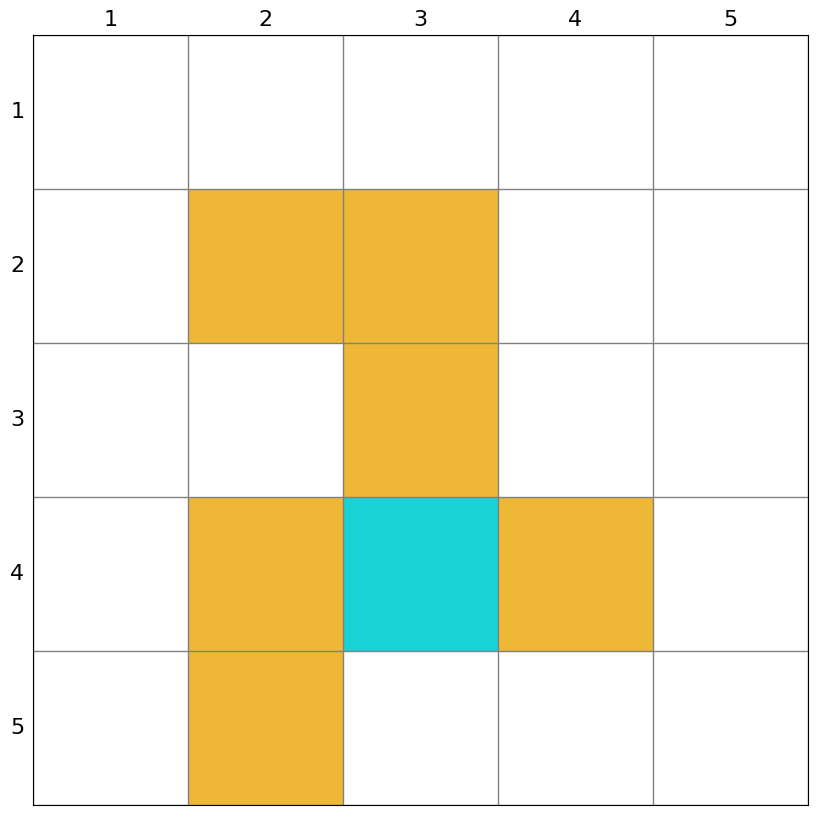

In [87]:
env = grid_env.GridEnv(size=5, target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], render_mode='')

In [88]:
def obtain_episode(env, policy, start_state, start_action, length):
        f"""

        :param policy: 由指定策略产生episode
        :param start_state: 起始state
        :param start_action: 起始action
        :param length: episode 长度
        :return: 一个 state,action,reward,next_state,next_action 序列
        """
        env.agent_location = env.state2pos(start_state)
        episode = []
        next_action = start_action
        next_state = start_state
        while length > 0:
            length -= 1
            state = next_state
            action = next_action
            _, reward, done, _, _ = env.step(action)
            next_state = env.pos2state(env.agent_location)
            next_action = np.random.choice(np.arange(len(policy[next_state])),
                                           p=policy[next_state])
            episode.append({"state": state, "action": action, "reward": reward, "next_state": next_state,
                            "next_action": next_action})
        return episode

In [89]:
def Q_learning_on_policy(env, alpha=0.001, num_episode=100000, gamma=0.99, epsilon=0.1):
    # Initialize parameters
    state_space_size = env.size ** 2
    action_space_size = env.action_space_size
    env.reset()
    start_state = env.pos2state(env.agent_location)
    feature_size = state_space_size * action_space_size  # 特征维度大小
    w = np.random.randn(feature_size) * 0.01
    policy = np.ones((state_space_size, action_space_size)) / action_space_size
    
    def feature_vector(state, action):
        """返回给定状态和动作的特征向量."""
        phi = np.zeros(feature_size)
        index = state * action_space_size + action
        phi[index] = 1
        return phi
    
    def q_value(state, action, w):
        """通过线性函数逼近计算 Q 值."""
        phi = feature_vector(state, action)
        return np.dot(w, phi)

    def policy_update(state, q_values, epsilon):
        A_s = np.arange(action_space_size)
        # Epsilon-greedy policy update
        action_star = np.argmax(q_values)
        policy[state] = epsilon / len(A_s)
        policy[state][action_star] = 1 - epsilon + (epsilon / len(A_s))

    # Function to take action according to policy π(s)
    def take_action(state):
        return np.random.choice(np.arange(action_space_size), p=policy[state])

    while num_episode > 0:
        done = False
        state = start_state
        num_episode -= 1
        while not done:  # Until we reach target state
            action = take_action(state)
            _,reward,done,_,_ = env.step(action)
            next_state = env.pos2state(env.agent_location)
             # 计算当前状态下的 Q 值
            q_value_current = q_value(state, action, w)

            # 计算下一状态的最大 Q 值
            q_value_next_max = np.max([q_value(next_state, a, w) for a in range(action_space_size)])

            # 目标值
            target = reward + gamma * q_value_next_max

            # TD误差
            td_error = target - q_value_current

            # 更新权重
            w += alpha * td_error * feature_vector(state, action)

            # Update policy
            policy_update(state, [q_value(state, a, w) for a in range(action_space_size)], epsilon)
            
            # Move to the next state
            state = next_state
    
    return policy

In [90]:
policy = Q_learning_on_policy(env)

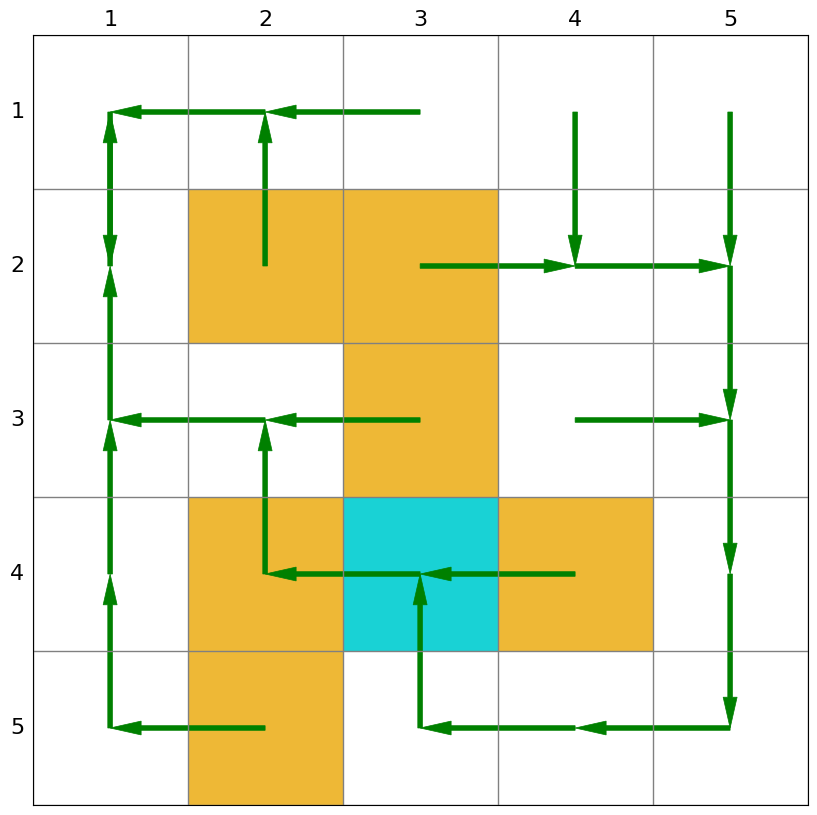

In [91]:
# 定义动作对应的方向
action_to_direction = {
    0: np.array([-1, 0]),
    1: np.array([0, 1]),
    2: np.array([1, 0]),
    3: np.array([0, -1]),
    4: np.array([0, 0]),
}
render = Render(target=[2, 3], forbidden=[[1, 1],[2, 1],[2, 2],[1, 3],[3, 3],[1, 4]], size=5)
# 绘制每个状态的最优动作
for state in range(policy.shape[0]):
    # 计算状态在网格中的位置
    row, col = env.state2pos(state)
    
    # 找出当前状态下的最优动作
    best_action = np.argmax(policy[state])
    
    # 根据最优动作绘制箭头
    render.draw_action(pos=[row, col], toward=action_to_direction[best_action])

# 显示结果
render.show_frame()